# NBA Winner Classifier

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
#pd.options.display.max_columns = None
#pd.set_option("display.max_colwidth", None)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
#pd.set_option("display.max_rows", None)
import model.train as train
import model.config as model_config
import utils
import model.dataset.season_game as sg
import utils_nba_winner_clf as utils_exp
import qgrid
from yellowbrick import classifier, features
from pandas_profiling import ProfileReport

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from boruta import BorutaPy

/home/nathaniel/anaconda3/envs/nba-predictor/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


## Setup

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%autosave 60

sns.set(style="whitegrid")

Autosaving every 60 seconds


### Utils functions

In [3]:
def filter_from(items, cond):
    return list(filter(cond, items))

In [4]:
def del_result_by(exp_name):
    global results_total
    results_total = filter_from(results_total, lambda i: i[0] != exp_name)
    utils_exp.exp_results = filter_from(utils_exp.exp_results, lambda i: i['exp_name'] != exp_name)

In [5]:
def get_result_by(exp_name):
    global results_total
    return next((x for x in results_total if x[0] == exp_name), None)

In [25]:
#del_result_by('reg_1_season')
#utils_exp.exp_results
#utils.deserialize_object(f'result_totals', [])

In [6]:
def show_qgrid(df_):
    qgrid_widget = qgrid.show_grid(df_, show_toolbar=True , grid_options={'forceFitColumns': False, 'defaultColumnWidth': 200})
    qgrid_widget

In [7]:
def plot_results(experiment_name, results, figsize=(20,10)):
    plt.figure(figsize=figsize)
    results_df = utils.map_results_to_df(results)
    a = sns.lineplot(
        data=results_df,
        x="season_test", y="prec", hue="model", style="model",
        markers=True, dashes=False)
    a.set_title(
        f"{experiment_name}-prec")
    a.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [8]:
def get_results_df():
    return pd.DataFrame(utils_exp.exp_results)

In [9]:
metrics = ['prec', 'bal_acc', 'roc_auc']

def print_prettier_exp_results(exp_name, metric='prec', filter_val=None):
    second_metric = 'bal_acc' if metric == 'prec' else 'prec'
    ba_df = get_results_df()[['exp_name', 'model',
       f'{metric}_mean', f'{metric}_std', f'{second_metric}_mean', f'{second_metric}_std']]
    cond = ba_df.exp_name == exp_name
    if filter_val is not None:
        cond = (ba_df.exp_name == exp_name) & (ba_df.model.isin(filter_val))
    return ba_df[cond].sort_values(by=[f"{metric}_mean"], ascending=False)

## Load Dataset

In [10]:
season_games = sg.load_season_games_dataset()

## Dataset


In [31]:
season_games.groupby(by="SEASON").count()["GAME_DATE_EST"]

SEASON
2002    1189
2003    1189
2004    1230
2005    1230
2006    1230
2007    1230
2008    1230
2009    1230
2010    1230
2011     990
2012    1229
2013    1230
2014    1230
2015    1230
2016    1230
2017    1230
2018    1230
2019    1059
Name: GAME_DATE_EST, dtype: int64

Podemos observar que no todas las temporadas tiene la misma cantidad de partidos. Esto es debido a la siguientes razones:

- 2011: Los jugadores hicieron una huelga debido a no estar de acuerdo con los salarios de los mismos y el limite salarial de las franquicias.
- 2012: Un partido entre el equipo de Boston e Indiana fue suspedindo el cual despues no fue reprogramado, y al final de la temporada se decidio ya no reprogramarlo debido a que la clasificacion a playoff ya estaba decidida y no afectaba el resultado.

Por tanto se seleccionaran solo las temporadas a partir del 2013(inclusive).

In [11]:
df = season_games[(season_games.SEASON >= 2010) & (season_games.SEASON <= 2017)]
seasons_size = len(df.SEASON.unique())
seasons = list(df.SEASON.unique())

In [12]:
print(df.shape)
df = df.dropna()
print(df.isnull().sum().sum())
print(df.shape)

(9599, 261)
0
(9461, 261)


In [190]:
df[df.SEASON >= 2012]

,SEASON_ID,TEAM_ID_HOME,TEAM_ABBREVIATION_HOME,TEAM_NAME_HOME,GAME_DATE,MATCHUP_HOME,WL_HOME,MIN_HOME,FGM_HOME,FGA_HOME,...,HOME_OREB_L10,HOME_DREB_L10,HOME_REB_L10,HOME_AST_L10,HOME_STL_L10,HOME_BLK_L10,HOME_TOV_L10,HOME_PF_L10,HOME_PTS_L10,HOME_PLUS_MINUS_L10
GAME_ID,,,,,,,,,,,,,,,,,,,,,
0021200019,22012,1610612739,CLE,Cleveland Cavaliers,2012-11-02,CLE vs. CHI,L,240,32,79,...,4.0,4.0,8.0,1.0,-1.0,-5.0,3.0,2.0,1.0,4.0
0021200021,22012,1610612740,NOH,New Orleans Hornets,2012-11-02,NOH vs. UTA,W,240,37,81,...,-11.0,-7.0,-18.0,2.0,-3.0,-2.0,1.0,-5.0,-18.0,-23.0
0021200022,22012,1610612760,OKC,Oklahoma City Thunder,2012-11-02,OKC vs. POR,W,240,39,76,...,2.0,16.0,18.0,-1.0,-4.0,0.0,6.0,0.0,-32.0,-12.0
0021200024,22012,1610612756,PHX,Phoenix Suns,2012-11-02,PHX vs. DET,W,240,40,92,...,1.0,7.0,8.0,-5.0,-2.0,8.0,2.0,8.0,-11.0,7.0
0021200025,22012,1610612747,LAL,Los Angeles Lakers,2012-11-02,LAL vs. LAC,L,240,34,68,...,7.0,-0.5,6.5,-2.5,-6.0,-5.5,-2.5,-2.0,-2.5,-18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0021701226,22017,1610612740,NOP,New Orleans Pelicans,2018-04-11,NOP vs. SAS,W,240,52,88,...,-2.3,4.4,2.1,6.1,1.2,0.4,2.9,-0.3,3.8,0.5
0021701227,22017,1610612760,OKC,Oklahoma City Thunder,2018-04-11,OKC vs. MEM,W,240,47,85,...,3.8,3.2,7.0,-1.8,1.9,-1.0,-2.7,0.7,11.6,14.8
0021701228,22017,1610612746,LAC,LA Clippers,2018-04-11,LAC vs. LAL,L,240,41,83,...,2.0,-5.5,-3.5,-1.7,0.2,-0.3,-1.3,-0.5,2.2,-1.5


## Experiments

### Setup

In [13]:
exp_prefix = "clf_"
#exp_group_name = "clf_experiments"
exp_group_name = "clf_experiments_boruta"
results_total = utils.deserialize_object(f'result_totals_{exp_group_name}', [])
utils_exp.exp_results = []
TARGET = "HOME_WINS"
exp_X_columns = model_config.X_COLS_BEST_BORUTA
exp_y_columns = model_config.Y_CLF_COL

models = utils_exp.get_clf_models()

sscv = utils.SeasonSeriesSplit(df)
df_sscv = sscv.get_df()
X = df_sscv[exp_X_columns]
y = df_sscv[TARGET]

### Feature selection

In [14]:
def dict_to_list(d):
    dictlist = []
    for key, value in d.items():
        temp = [key,value]
        dictlist.append(temp)
    return pd.DataFrame(data=dictlist)

In [222]:
# instantiate random forest
from collections import defaultdict

## RandomForest
model = models[4][1]

folds, train_seasons, test_seasons = sscv.split(train_size=1, test_size=1)
folds_selected_features = defaultdict(int)
boruta_selector = BorutaPy(model, n_estimators = 200, random_state = 0)
list_selected_features = []
for train_idx, test_idx in folds[:]:    
    X_train, X_test = X.loc[train_idx], X.loc[test_idx]
    y_train, y_test = y.loc[train_idx], y.loc[test_idx]
    y_true = y_test
    # fit boruta
    boruta_selector.fit(np.array(X_train), np.array(y_train))
    boruta_ranking = boruta_selector.ranking_
    selected_features = np.array(exp_X_columns)[boruta_ranking <= 2]
    list_selected_features.append(selected_features)
    for f in selected_features:
        folds_selected_features[f]+=1
#dict_to_list(folds_selected_features)
# # store results
# boruta_ranking = boruta_selector.ranking_
# selected_features = np.array(feature_names)[boruta_ranking <= 2]

BorutaPy(estimator=RandomForestClassifier(max_depth=20, n_estimators=200,
                                          n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x7F1E1E1039E0),
         n_estimators=200, random_state=RandomState(MT19937) at 0x7F1E1E1039E0)

BorutaPy(estimator=RandomForestClassifier(max_depth=20, n_estimators=200,
                                          n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x7F1E1E1039E0),
         n_estimators=200, random_state=RandomState(MT19937) at 0x7F1E1E1039E0)

BorutaPy(estimator=RandomForestClassifier(max_depth=20, n_estimators=200,
                                          n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x7F1E1E1039E0),
         n_estimators=200, random_state=RandomState(MT19937) at 0x7F1E1E1039E0)

BorutaPy(estimator=RandomForestClassifier(max_depth=20, n_estimators=200,
                                          n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x7F1E1E1039E0),
         n_estimators=200, random_state=RandomState(MT19937) at 0x7F1E1E1039E0)

BorutaPy(estimator=RandomForestClassifier(max_depth=20, n_estimators=200,
                                          n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x7F1E1E1039E0),
         n_estimators=200, random_state=RandomState(MT19937) at 0x7F1E1E1039E0)

BorutaPy(estimator=RandomForestClassifier(max_depth=20, n_estimators=200,
                                          n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x7F1E1E1039E0),
         n_estimators=200, random_state=RandomState(MT19937) at 0x7F1E1E1039E0)

BorutaPy(estimator=RandomForestClassifier(max_depth=20, n_estimators=200,
                                          n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x7F1E1E1039E0),
         n_estimators=200, random_state=RandomState(MT19937) at 0x7F1E1E1039E0)

In [223]:
f_df = dict_to_list(folds_selected_features)

In [224]:
f_df.sort_values(by=[1, 0], ascending=False)
#f_df[f_df[1] > 2]
final_selected_features = list(f_df[0].unique())

,0,1
13,PLUS_MINUS_MEAN_AWAY,7
10,HOME_PLUS_MINUS_ML10,7
9,HOME_PLUS_MINUS_MEAN,7
8,HOME_PLUS_MINUS_L10,7
4,HOME_FG_PCT_MEAN,7
3,HOME_FG3_PCT,7
17,W_L_CUM_HOME,6
14,PLUS_MINUS_MEAN_HOME,6
12,PLUS_MINUS_L10_HOME,6
6,HOME_FT_PCT,6


In [247]:
best_boruta = list_selected_features[3]
sorted(best_boruta)
best_boruta

['FG_PCT_MEAN_AWAY',
 'FG_PCT_MEAN_HOME',
 'FT_PCT_ML10_AWAY',
 'HOME_FG3_PCT',
 'HOME_FG_PCT_L10',
 'HOME_FG_PCT_MEAN',
 'HOME_FT_PCT',
 'HOME_FT_PCT_ML10',
 'HOME_PLUS_MINUS_L10',
 'HOME_PLUS_MINUS_MEAN',
 'HOME_PLUS_MINUS_ML10',
 'PLUS_MINUS_L10_AWAY',
 'PLUS_MINUS_L10_HOME',
 'PLUS_MINUS_MEAN_AWAY',
 'PLUS_MINUS_MEAN_HOME',
 'W_L_CUM_AWAY',
 'W_L_CUM_HOME']

array(['FG_PCT_MEAN_AWAY', 'FG_PCT_MEAN_HOME', 'FT_PCT_ML10_AWAY',
       'HOME_FG3_PCT', 'HOME_FG_PCT_L10', 'HOME_FG_PCT_MEAN',
       'HOME_FT_PCT', 'HOME_FT_PCT_ML10', 'HOME_PLUS_MINUS_L10',
       'HOME_PLUS_MINUS_MEAN', 'HOME_PLUS_MINUS_ML10',
       'PLUS_MINUS_L10_AWAY', 'PLUS_MINUS_L10_HOME',
       'PLUS_MINUS_MEAN_AWAY', 'PLUS_MINUS_MEAN_HOME', 'W_L_CUM_AWAY',
       'W_L_CUM_HOME'], dtype='<U20')

#### Test best features

In [225]:
#[x for x in exp_X_columns if x not in final_selected_features]
X_boruta = df_sscv[final_selected_features]
y_boruta = df_sscv[TARGET]

experiment_name = f"{exp_prefix}2_seasons_boruta"
del_result_by(experiment_name)
folds, train_seasons, test_seasons = sscv.split(train_size=2, test_size=1)


params = (experiment_name, models, folds, train_seasons, test_seasons, X_boruta, y_boruta)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment clf_2_seasons_boruta
Done


,exp_name,model,precision_mean,precision_std
3,clf_2_seasons_boruta,SVM,0.759779,0.015470
0,clf_2_seasons_boruta,LR,0.759003,0.014059
4,clf_2_seasons_boruta,RF,0.749202,0.010102
5,clf_2_seasons_boruta,XGB,0.747632,0.009149
6,clf_2_seasons_boruta,LGB,0.744206,0.009400
2,clf_2_seasons_boruta,DT,0.705247,0.009921
1,clf_2_seasons_boruta,KNN,0.683868,0.022084


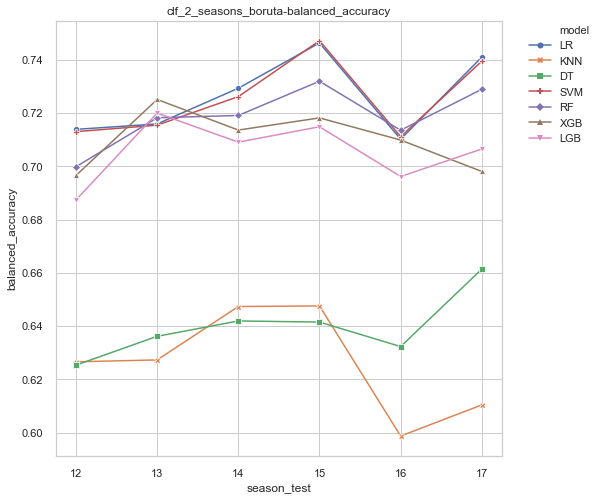

In [226]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,8))

#### Test specific best feature set

In [239]:
for idx, features in enumerate(list_selected_features):
    X_boruta = df_sscv[features]
    y_boruta = df_sscv[TARGET]

    experiment_name = f"{exp_prefix}2_seasons_boruta_specific_{idx}"
    del_result_by(experiment_name)
    folds, train_seasons, test_seasons = sscv.split(train_size=2, test_size=1)

    params = (experiment_name, models, folds, train_seasons, test_seasons, X_boruta, y_boruta)
    names, results = utils_exp.run_experiment(*params)
    results_total.append((experiment_name, results))
    #print_prettier_exp_results(experiment_name)

Running experiment clf_2_seasons_boruta_specific_0
Done
Running experiment clf_2_seasons_boruta_specific_1
Done
Running experiment clf_2_seasons_boruta_specific_2
Done
Running experiment clf_2_seasons_boruta_specific_3
Done
Running experiment clf_2_seasons_boruta_specific_4
Done
Running experiment clf_2_seasons_boruta_specific_5
Done
Running experiment clf_2_seasons_boruta_specific_6
Done


#### Test custom best feature set

In [254]:
X_COLS_BEST_BORUTA = ['FG_PCT_MEAN_AWAY',
                      'FG_PCT_MEAN_HOME',
                      'FT_PCT_ML10_AWAY',
                      'HOME_FG3_PCT',
                      'HOME_FG_PCT_L10',
                      'HOME_FG_PCT_MEAN',
                      'HOME_FT_PCT',
                      'HOME_FT_PCT_ML10',
                      'HOME_PLUS_MINUS_L10',
                      'HOME_PLUS_MINUS_MEAN',
                      'HOME_PLUS_MINUS_ML10',
                      'PLUS_MINUS_L10_AWAY',
                      'PLUS_MINUS_L10_HOME',
                      'PLUS_MINUS_MEAN_AWAY',
                      'PLUS_MINUS_MEAN_HOME',
                      'W_L_CUM_AWAY',
                      'W_L_CUM_HOME']
X_boruta = df_sscv[X_COLS_BEST_BORUTA]
y_boruta = df_sscv[TARGET]

experiment_name = f"{exp_prefix}2_seasons_boruta_custom"
del_result_by(experiment_name)
folds, train_seasons, test_seasons = sscv.split(train_size=2, test_size=1)

params = (experiment_name, models, folds, train_seasons, test_seasons, X_boruta, y_boruta)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))
print_prettier_exp_results(experiment_name)

Running experiment clf_2_seasons_boruta_custom
Done


,exp_name,model,precision_mean,precision_std
73,clf_2_seasons_boruta_custom,SVM,0.760366,0.011854
70,clf_2_seasons_boruta_custom,LR,0.760026,0.011737
74,clf_2_seasons_boruta_custom,RF,0.755667,0.010853
75,clf_2_seasons_boruta_custom,XGB,0.748373,0.005121
76,clf_2_seasons_boruta_custom,LGB,0.743551,0.005716
72,clf_2_seasons_boruta_custom,DT,0.697575,0.008015
71,clf_2_seasons_boruta_custom,KNN,0.684097,0.016000


### Experiment using 1 season

In [83]:
experiment_name = f"{exp_prefix}1_season"

In [94]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.split(train_size=1, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

,exp_name,model,prec_mean,prec_std,bal_acc_mean,bal_acc_std
3,clf_1_season,SVM,0.758347,0.014884,0.724194,0.013593
0,clf_1_season,L2R,0.755105,0.015299,0.722708,0.015391
4,clf_1_season,RF,0.751207,0.011320,0.715496,0.006765
5,clf_1_season,XGB,0.742703,0.012384,0.700939,0.007753
6,clf_1_season,LGB,0.740785,0.011199,0.699728,0.009089
2,clf_1_season,DT,0.702880,0.009494,0.644084,0.005554
1,clf_1_season,KNN,0.684978,0.022979,0.625833,0.017364


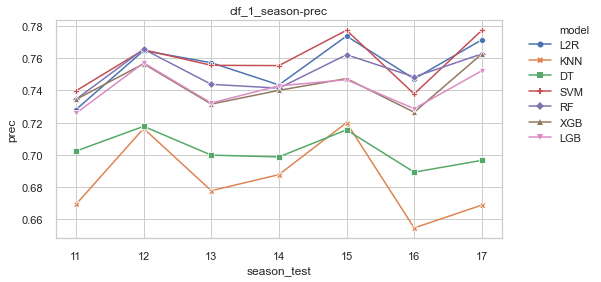

In [95]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,4))

### Experiment using StandardScaler

In [96]:
experiment_name = f"{exp_prefix}scaled_data"

In [97]:
del_result_by(experiment_name)

num_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])
preprocessor = ColumnTransformer([
        ('numerical', num_pipeline, exp_X_columns)
    ], remainder='passthrough')
#transformed_data = preprocessor.fit_transform(df)

folds, train_seasons, test_seasons = sscv.split(train_size=1, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y, preprocessor)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment clf_scaled_data
Done


,exp_name,model,prec_mean,prec_std,bal_acc_mean,bal_acc_std
7,clf_scaled_data,L2R,0.758111,0.013630,0.723486,0.012277
10,clf_scaled_data,SVM,0.754812,0.015591,0.719942,0.013193
11,clf_scaled_data,RF,0.751825,0.011584,0.716333,0.007072
12,clf_scaled_data,XGB,0.743861,0.013287,0.702241,0.007732
13,clf_scaled_data,LGB,0.741835,0.009468,0.700751,0.006070
8,clf_scaled_data,KNN,0.738634,0.021801,0.694440,0.019026
9,clf_scaled_data,DT,0.702235,0.009749,0.643174,0.006196


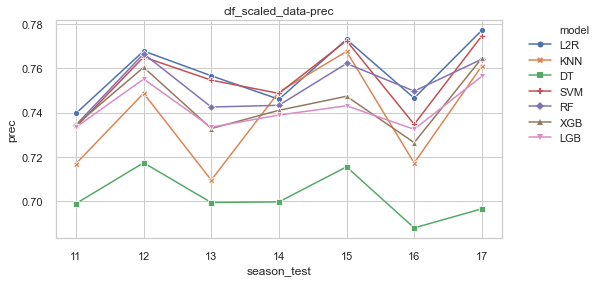

In [98]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,4))


### Experiment using MinMaxScaler

In [99]:
experiment_name = f"{exp_prefix}minmax_data"

In [100]:
del_result_by(experiment_name)

num_pipeline = Pipeline([
    ('minmax_scaler', MinMaxScaler())
])
preprocessor = ColumnTransformer([
        ('numerical', num_pipeline, exp_X_columns)
    ], remainder='passthrough')
#transformed_data = preprocessor.fit_transform(df)

folds, train_seasons, test_seasons = sscv.split(train_size=1, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y, preprocessor)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment clf_minmax_data
Done


,exp_name,model,prec_mean,prec_std,bal_acc_mean,bal_acc_std
17,clf_minmax_data,SVM,0.754102,0.017009,0.720450,0.016176
14,clf_minmax_data,L2R,0.753213,0.017100,0.721644,0.016000
18,clf_minmax_data,RF,0.751920,0.011399,0.716199,0.007013
19,clf_minmax_data,XGB,0.743587,0.013304,0.701806,0.007648
20,clf_minmax_data,LGB,0.742297,0.015711,0.699402,0.009036
15,clf_minmax_data,KNN,0.740143,0.024627,0.697381,0.019925
16,clf_minmax_data,DT,0.702588,0.009756,0.643605,0.006586


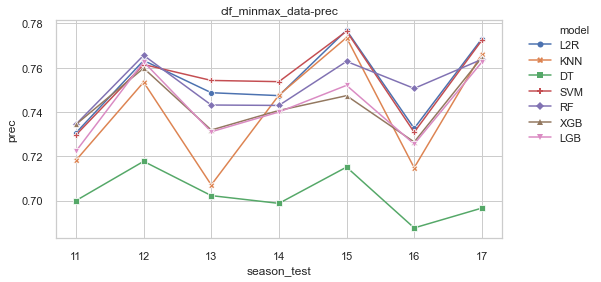

In [101]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,4))

### Experiment: train: 2s; test: 1s

In [86]:
experiment_name = f"{exp_prefix}2_seasons"

In [87]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.split(train_size=2, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)



Running experiment clf_2_seasons
Done


,exp_name,model,prec_mean,prec_std,bal_acc_mean,bal_acc_std
3,clf_2_seasons,SVM,0.760366,0.011854,0.728416,0.012863
0,clf_2_seasons,L2R,0.759985,0.012127,0.728682,0.014793
4,clf_2_seasons,RF,0.758332,0.011720,0.724693,0.010767
5,clf_2_seasons,XGB,0.748373,0.005121,0.706205,0.006501
6,clf_2_seasons,LGB,0.743551,0.005716,0.702446,0.006115
2,clf_2_seasons,DT,0.697575,0.008015,0.635182,0.010399
1,clf_2_seasons,KNN,0.684097,0.016000,0.625068,0.013547


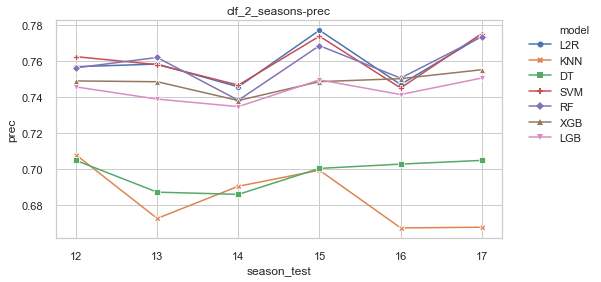

In [92]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,4))

### Experiment: train: 3s; test: 1s

In [151]:
experiment_name = f"{exp_prefix}3_seasons"

In [106]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.split(train_size=3, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment clf_3_seasons
Done


,exp_name,model,prec_mean,prec_std,bal_acc_mean,bal_acc_std
28,clf_3_seasons,L2R,0.757844,0.013889,0.730301,0.012957
31,clf_3_seasons,SVM,0.757212,0.013544,0.729108,0.012238
32,clf_3_seasons,RF,0.752356,0.009076,0.720751,0.007395
33,clf_3_seasons,XGB,0.746282,0.008515,0.708723,0.006046
34,clf_3_seasons,LGB,0.743054,0.007359,0.706375,0.004760
30,clf_3_seasons,DT,0.697106,0.013013,0.638202,0.006976
29,clf_3_seasons,KNN,0.682957,0.015314,0.627788,0.017356


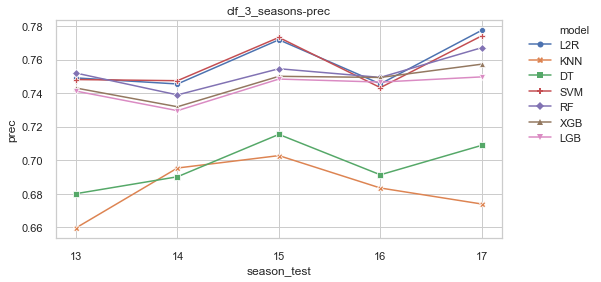

In [152]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,4))

### Experiment train: 3q ; test: 1q

In [153]:
experiment_name = f"{exp_prefix}3q_1q"

In [109]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.quarter_split(train_size=3, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment clf_3q_1q
Done


,exp_name,model,prec_mean,prec_std,bal_acc_mean,bal_acc_std
38,clf_3q_1q,SVM,0.757987,0.035630,0.720017,0.028084
35,clf_3q_1q,L2R,0.757478,0.038065,0.719508,0.027014
39,clf_3q_1q,RF,0.752015,0.031633,0.714691,0.022709
40,clf_3q_1q,XGB,0.745309,0.031751,0.700164,0.024864
41,clf_3q_1q,LGB,0.739397,0.034459,0.694151,0.027814
37,clf_3q_1q,DT,0.703361,0.038023,0.639813,0.029189
36,clf_3q_1q,KNN,0.682101,0.036913,0.620113,0.026394


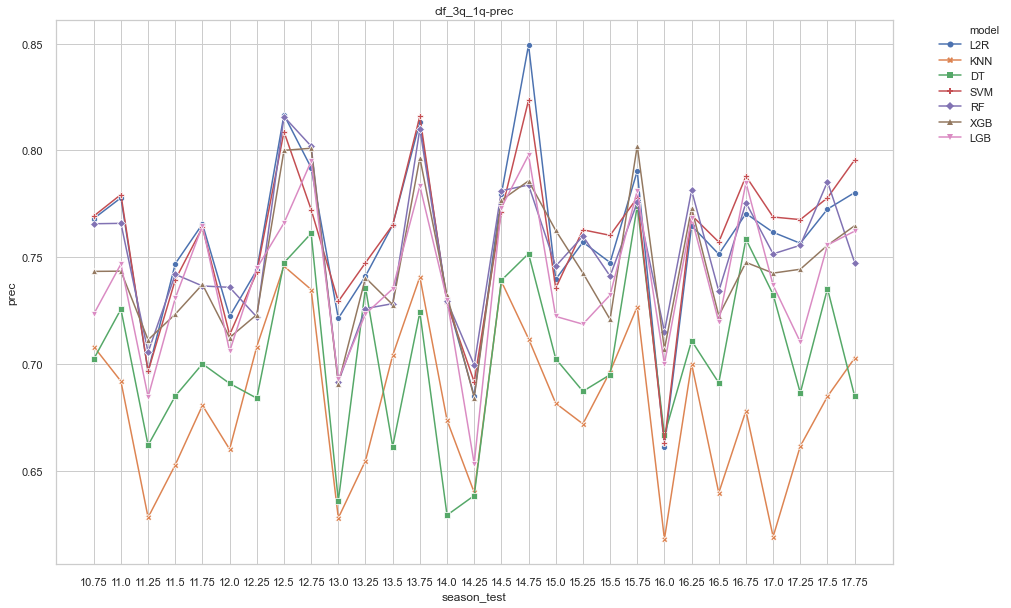

In [160]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(15, 10))

### Experiment train: 4q ; test: 2q

In [161]:
experiment_name = f"{exp_prefix}4q_2q"

In [112]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.quarter_split(train_size=4, test_size=2)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment clf_4q_2q
Done


,exp_name,model,prec_mean,prec_std,bal_acc_mean,bal_acc_std
45,clf_4q_2q,SVM,0.758336,0.024969,0.724630,0.019345
42,clf_4q_2q,L2R,0.755283,0.024149,0.722776,0.019320
46,clf_4q_2q,RF,0.751316,0.022047,0.716068,0.018045
47,clf_4q_2q,XGB,0.744314,0.019757,0.702514,0.015337
48,clf_4q_2q,LGB,0.742823,0.020706,0.701627,0.019839
44,clf_4q_2q,DT,0.705104,0.020331,0.644024,0.022800
43,clf_4q_2q,KNN,0.683321,0.029807,0.624786,0.023276


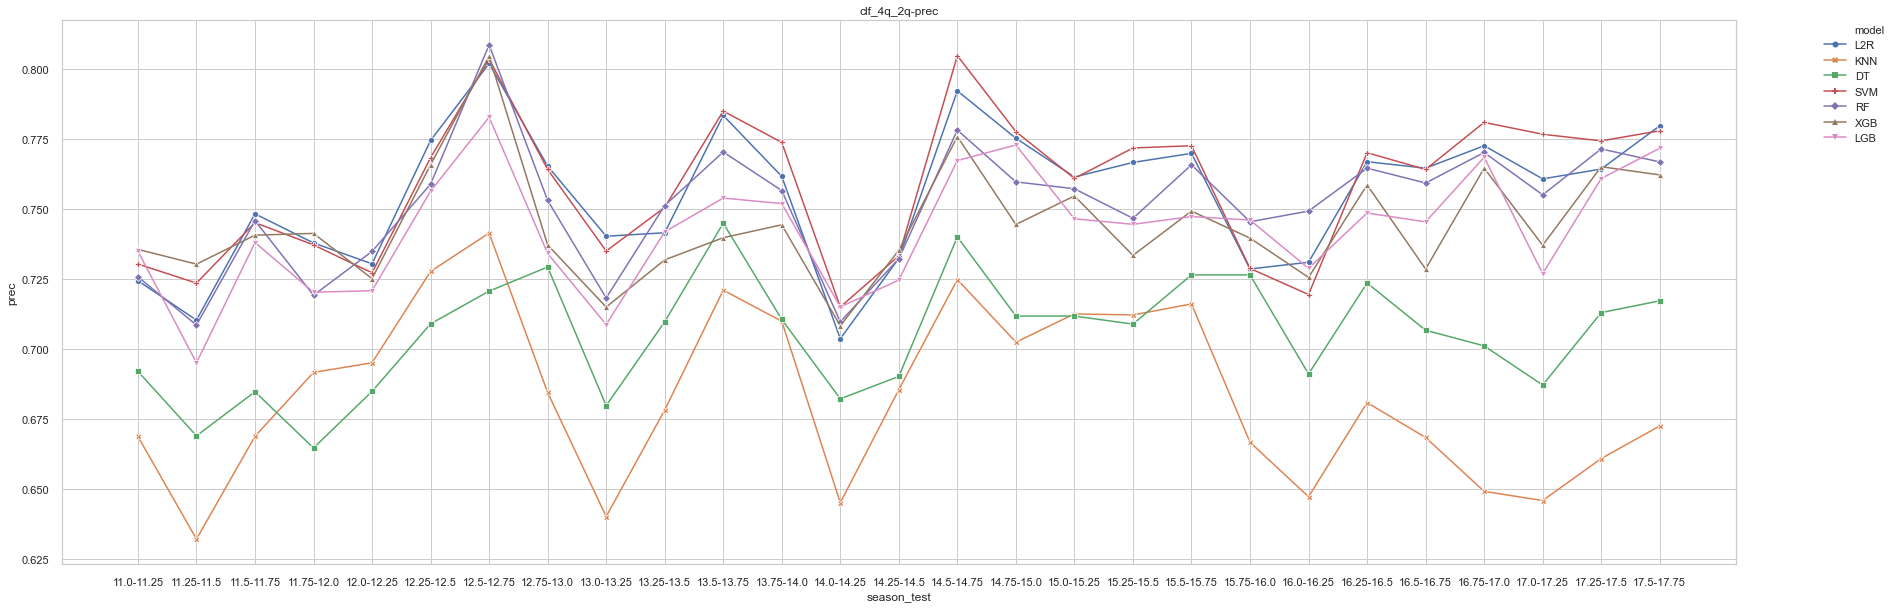

In [166]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(30,10))

### Experiment remove first 1q ; train: 2q ; test: 1q

En este experimento se eliminara el primer cuarto de cada temporada, y se entrenara el modelo con los 2 siguientes cuartos, y como test 1 cuarto de temporada. La ventana deslisante sera de 1 cuarto.

In [167]:
experiment_name = f"{exp_prefix}r1q_2q_1q"

In [115]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.quarter_split(train_size=2, test_size=1, skip=[0.25])
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment clf_r1q_2q_1q
Done


,exp_name,model,prec_mean,prec_std,bal_acc_mean,bal_acc_std
52,clf_r1q_2q_1q,SVM,0.762525,0.032974,0.720676,0.027711
49,clf_r1q_2q_1q,L2R,0.762525,0.036994,0.720547,0.027338
53,clf_r1q_2q_1q,RF,0.754506,0.032095,0.716079,0.023124
54,clf_r1q_2q_1q,XGB,0.749320,0.030775,0.703167,0.025238
55,clf_r1q_2q_1q,LGB,0.746298,0.030428,0.699489,0.025269
51,clf_r1q_2q_1q,DT,0.706855,0.041086,0.641979,0.033124
50,clf_r1q_2q_1q,KNN,0.684247,0.038818,0.619829,0.031437


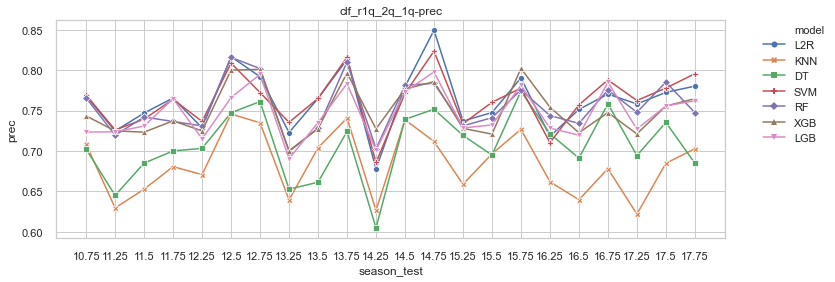

In [172]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(12,4))

### Experiments comparison

In [117]:
utils.serialize_object(exp_group_name, utils_exp.exp_results)

In [118]:
utils_exp.exp_results = utils.deserialize_object(exp_group_name)
exp_df = get_results_df()

In [187]:
ba_df = exp_df[['exp_name', 'model',
       'prec_mean', 'prec_std', 'bal_acc_mean', 'bal_acc_std']]

In [120]:
#show_qgrid(exp_df)
qgrid_widget = qgrid.show_grid(exp_df, show_toolbar=True , grid_options={'forceFitColumns': False, 'defaultColumnWidth': 200})
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [188]:
ba_df.sort_values(
    by=["prec_mean"]
    , ascending=False)[:6].reset_index().drop(labels=["index"], axis=1)

,exp_name,model,prec_mean,prec_std,bal_acc_mean,bal_acc_std
0,clf_r1q_2q_1q,SVM,0.762525,0.032974,0.720676,0.027711
1,clf_r1q_2q_1q,L2R,0.762525,0.036994,0.720547,0.027338
2,clf_2_seasons,SVM,0.760366,0.011854,0.728416,0.012863
3,clf_2_seasons,L2R,0.760026,0.011737,0.728800,0.014623
4,clf_1_season,SVM,0.758347,0.014884,0.724194,0.013593
5,clf_4q_2q,SVM,0.758336,0.024969,0.724630,0.019345


### Plot experiment results

In [122]:
utils.serialize_object("results", utils_exp.exp_results)
utils.serialize_object("results_total", results_total)

#### Balance Accuracy

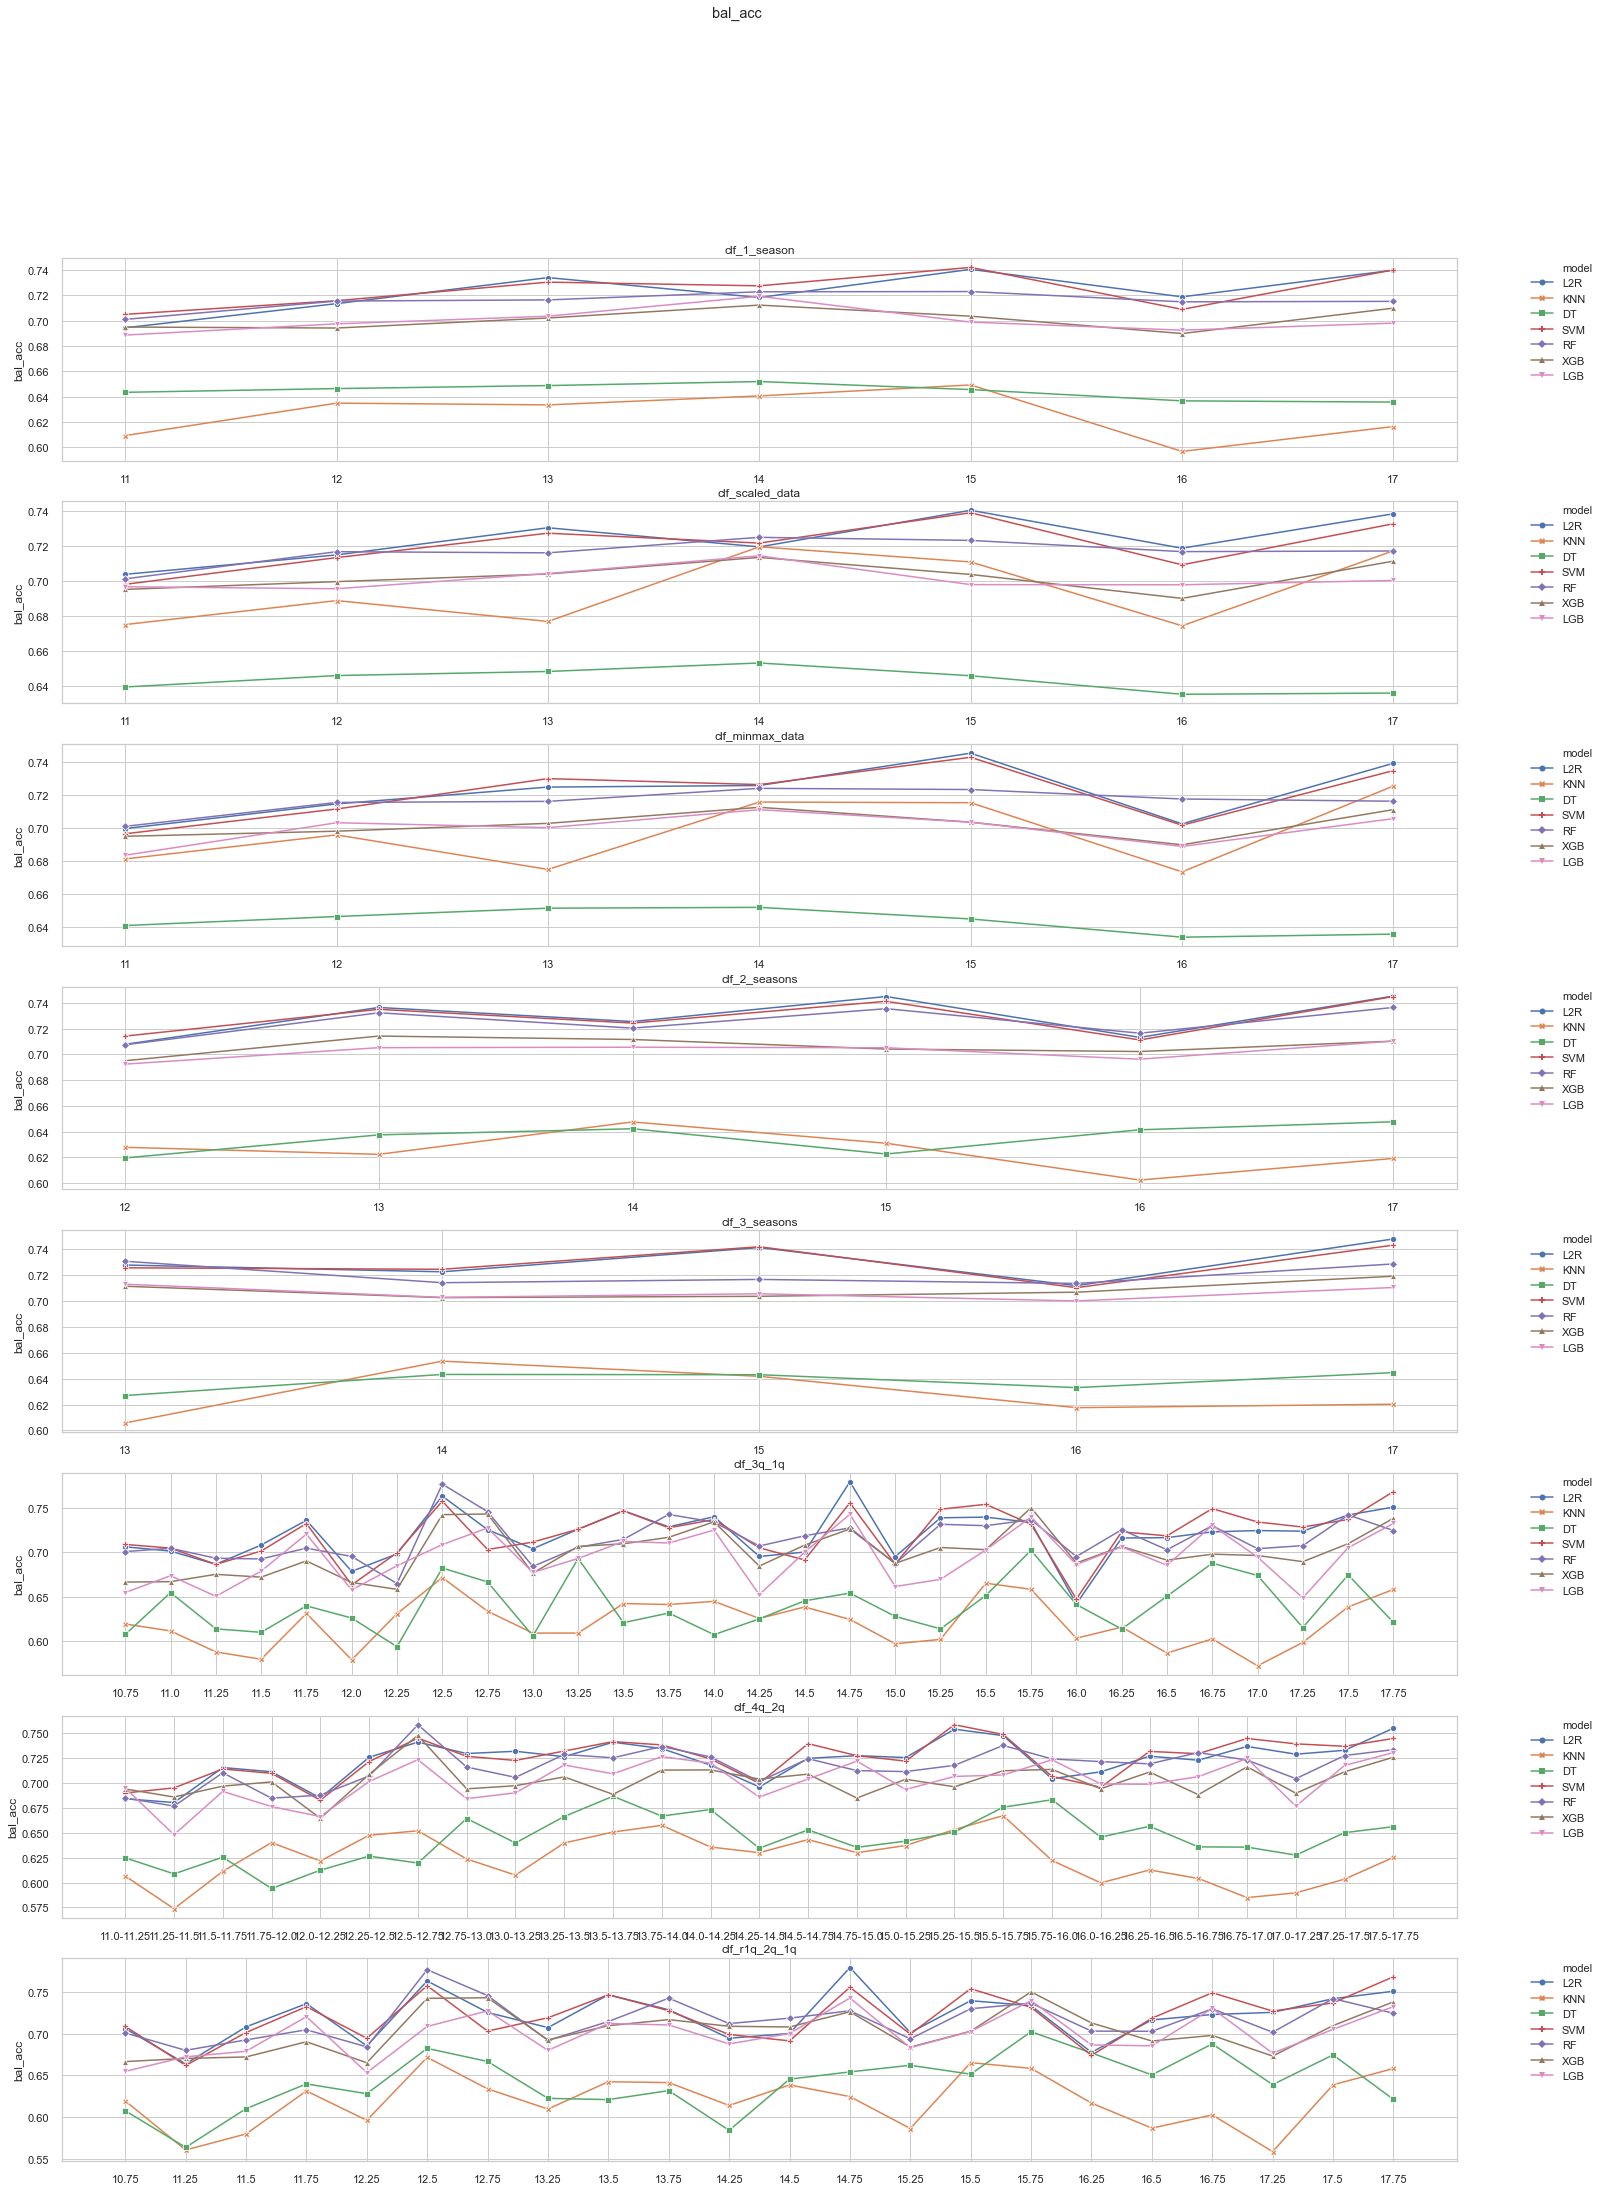

In [123]:
utils.plot_to_compare_experiments(
    results_total,
    metric="bal_acc",
    figsize=(25, 35),
    use_pointplot=True
)

#### Precision

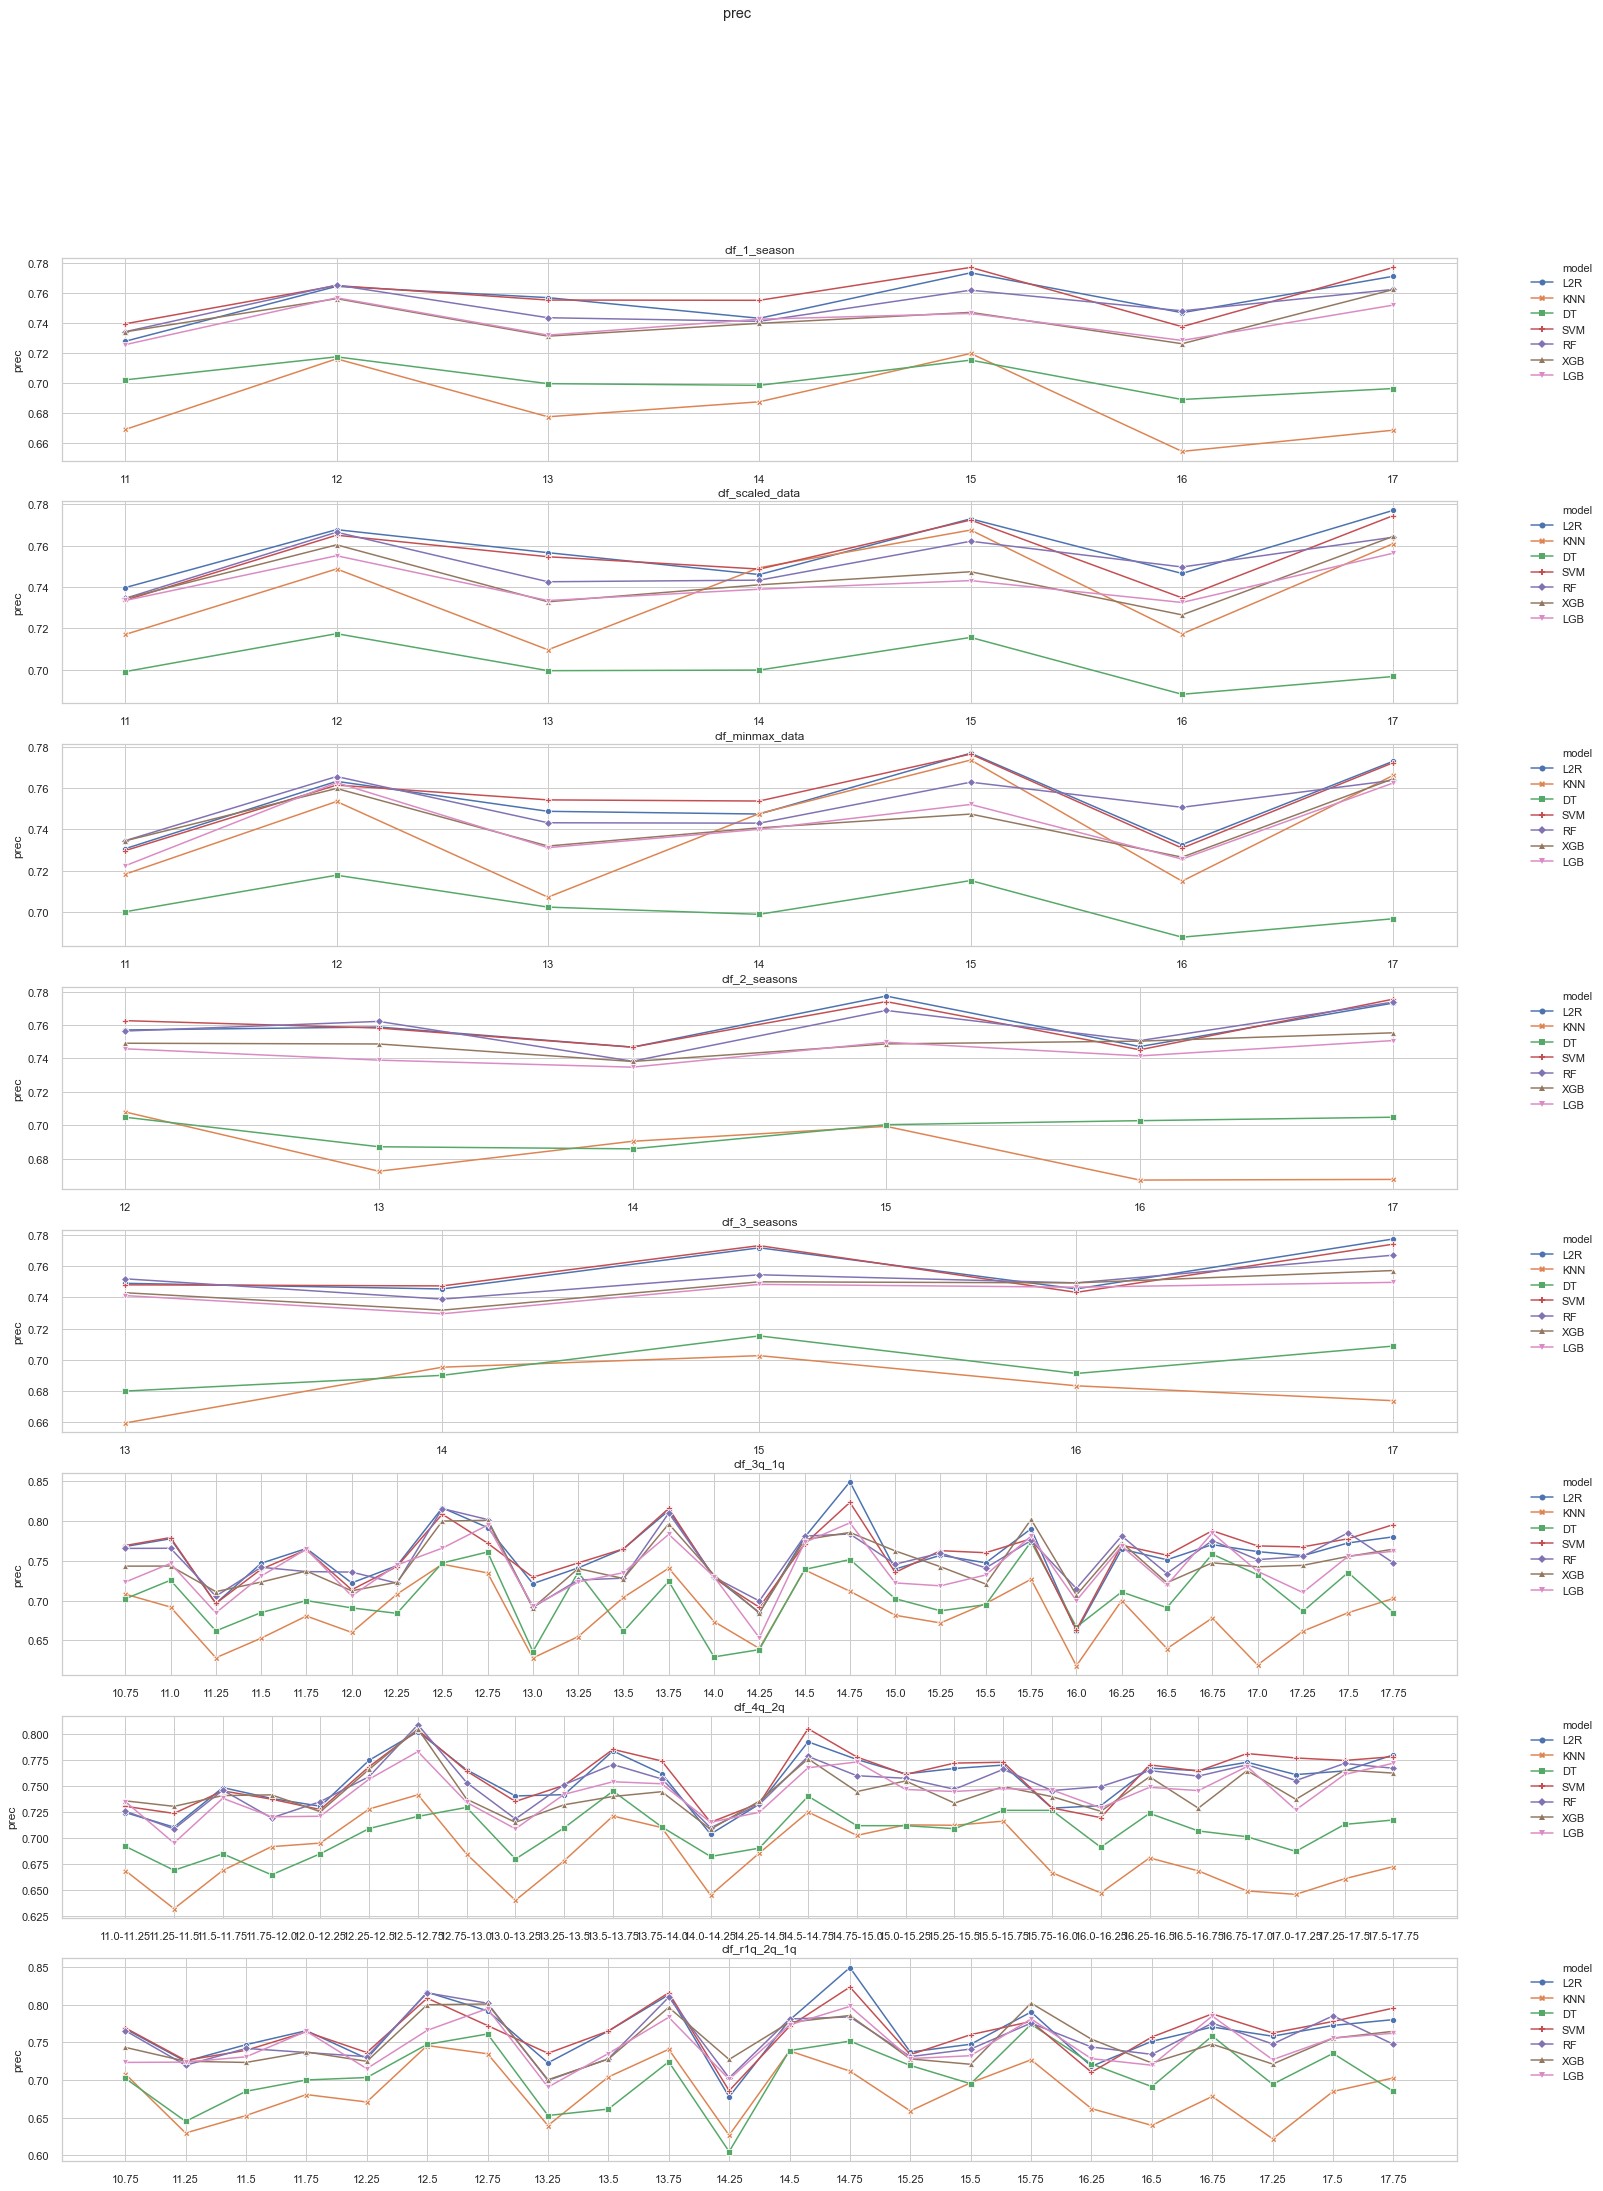

In [124]:
utils.plot_to_compare_experiments(
    results_total,
    metric="prec",
    figsize=(25, 35),
    use_pointplot=True
)

#### ROC AUC

In [ ]:
utils.plot_to_compare_experiments(
    results_total,
    metric="roc_auc",
    figsize=(25, 35),
    use_pointplot=True
)

### Optimization

#### Imports

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb

from sklearn.metrics import precision_score, \
        balanced_accuracy_score
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from hpsklearn import HyperoptEstimator
import hpsklearn
from hyperopt.pyll import scope, as_apply
from hyperopt import SparkTrials, STATUS_OK

WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely


#### Dataset

In [18]:
op_df = season_games[(season_games.SEASON >= 2010) & (season_games.SEASON <= 2017)]

##### Seasons

In [19]:
op_df.SEASON.unique()

array([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017])

##### Clean Data

In [20]:
print(op_df.shape)
op_df = op_df.dropna()
print(op_df.isnull().sum().sum())
print(op_df.isna().sum().sum())
print(op_df.shape)

(9599, 261)
0
0
(9461, 261)


#### setup

In [21]:
exp_prefix = "clf_"
#exp_group_name = "clf_experiments"
exp_group_name = "clf_op"
results_total = utils.deserialize_object(f'result_totals_{exp_group_name}', [])

op_models = utils_exp.get_clf_models()

op_sscv = utils.SeasonSeriesSplit(op_df)
op_df_sscv = op_sscv.get_df()
op_X = op_df_sscv[exp_X_columns]
op_y = op_df_sscv[TARGET]

#### Utils

In [22]:
def walk_forward_val_mean_score(input_model):
    metric_results = []
    for train_idx, test_idx in folds:
        X_train, X_test = X.loc[train_idx], X.loc[test_idx]
        y_train, y_test = y.loc[train_idx], y.loc[test_idx]
        y_true = y_test
        
        pipeline = Pipeline(steps=[
                ('model', input_model)])
        
        model = pipeline
        fit_info = pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        metric_results.append(balanced_accuracy_score(y_true, y_pred)) 

    return np.mean(metric_results)  


def walk_forward_sklearn(estim):
    metric_results = []
    for train_idx, test_idx in folds:
        X_train, X_test = X.loc[train_idx], X.loc[test_idx]
        y_train, y_test = y.loc[train_idx], y.loc[test_idx]
        y_true = y_test
        
        estim.fit(X_train, y_train)
        print(estim.score(X_test, y_test))
        print(estim.best_model())

#### Optimization

In [23]:
folds, train_seasons, test_seasons = op_sscv.split(train_size=2, test_size=1)

In [24]:
# name = 'clf'
# models = [
#     #hpsklearn.svc(name + '.SVM'),
#     #svc_linear
#     #hpsklearn.random_forest(name + '.RF'),
#     #hpsklearn.xgboost_classification(name + '.XGB'),
#     #hpsklearn.lightgbm_classification(name + '.LGB')
#     hpsklearn.svc_linear(name + 'SVM')
# ]


# estim = HyperoptEstimator(classifier=hp.choice('%s' % name, models),
#                           #preprocessing=hpsklearn.any_preprocessing('my_pre'),
#                           preprocessing=None,
#                           algo=tpe.suggest,
#                           max_evals=50,
#                           trial_timeout=120)



# for train_idx, test_idx in folds:
#     X_train, X_test = X.loc[train_idx], X.loc[test_idx]
#     y_train, y_test = y.loc[train_idx], y.loc[test_idx]
#     y_true = y_test
#     estim.fit(X_train, y_train)
#     estim.score(X_test, y_test)

# print(estim.best_model())

#### LGB

In [ ]:
space = {
    'max_depth': scope.int(hp.uniform('max_depth', 1, 11)),
    'num_leaves': scope.int(hp.uniform('num_leaves', 2, 121)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.5)) - 0.0001,
    'n_estimators': scope.int(hp.quniform('n_estimators', 100, 6000, 200)),
    'gamma': hp.loguniform('gamma', np.log(0.0001), np.log(5)) - 0.0001,
    'min_child_weight': scope.int(hp.loguniform('min_child_weight', np.log(1), np.log(100))),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.5, 1),
    'reg_alpha': hp.loguniform('reg_alpha', np.log(0.0001), np.log(1)) - 0.0001,
    'reg_lambda': hp.loguniform('reg_lambda', np.log(1), np.log(4)),
    #boosting_type: hp.choice(name, ['gbdt', 'dart', 'goss'])
    'boosting_type': hp.choice('boosting_type', ['gbdt'])
}

default_hiperparameters = {
    'objective': 'binary',
    #'random_state': 0
}

def objective(space):
    print(space)
    hiperparameters = {**default_hiperparameters, **space}
    model = lgb.LGBMClassifier(
        **hiperparameters
    )

    accuracy = walk_forward_val_mean_score(model)

    return {'loss': -accuracy, 'status': STATUS_OK }

spark_trials = SparkTrials(parallelism=4)
#trials = Trials()
best = fmin(
        fn=objective,
        space=space,
        algo=tpe.suggest,
        max_evals=150,
        trials=spark_trials,
        rstate=np.random.RandomState(seed=0),
        return_argmin=False
    )
best

 13%|█▎        | 19/150 [17:35<2:14:13, 61.47s/trial, best loss: -0.7283632006119398]

#### Experiment

In [28]:

op_model = [
#     ('SVM', SVC(C=0.012697068361313206, cache_size=512, degree=1, gamma='auto',
#     kernel='linear', max_iter=54006698.0, random_state=4,
#     tol=8.876549929680088e-05)),
#     ("LGB", lgb.LGBMClassifier(boosting_type='dart', colsample_bytree=0.5774517052371843,
#                learning_rate=0.001088309810177423, max_delta_step=0,
#                max_depth=9, min_child_weight=22, n_estimators=3200, n_jobs=1,
#                num_leaves=19, objective='binary',
#                reg_alpha=0.0009920138640525102, reg_lambda=2.593449218886441,
#                scale_pos_weight=1, seed=3, subsample=0.980626212446999)),
    ('LGB', lgb.LGBMClassifier(
        **{'boosting_type': 'gbdt',
 'colsample_bylevel': 0.7911287100076613,
 'colsample_bytree': 0.8603649524735973,
 'gamma': 4.43302024049316,
 'learning_rate': 0.0009592641656631401,
 'max_depth': 3,
 'min_child_weight': 17,
 'n_estimators': 4000,
 'num_leaves': 72,
 'reg_alpha': 1.0620929521387056e-05,
 'reg_lambda': 1.3493051864867296,
 'subsample': 0.9099643557200597}
    )),
    ('LGB2', lgb.LGBMClassifier(
        **{'boosting_type': 'gbdt',
 'colsample_bylevel': 0.7729132785100075,
 'colsample_bytree': 0.8237696281830607,
 'gamma': 0.02767717987305845,
 'learning_rate': 0.004301947480128295,
 'max_depth': 5,
 'min_child_weight': 4,
 'n_estimators': 1400,
 'num_leaves': 101,
 'reg_alpha': 0.0004447330199770369,
 'reg_lambda': 1.1974372235637603,
 'subsample': 0.6524249725030407}
    )),
    ("XGB", xgb.XGBClassifier(base_score=0.5, booster='gbtree',
              colsample_bylevel=0.9274316569938598, colsample_bynode=1,
              colsample_bytree=0.768350297812703, gamma=0.275559851080226,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.00383884756104703, max_delta_step=0, max_depth=2,
              min_child_weight=3, monotone_constraints='()',
              n_estimators=5600, n_jobs=1, num_parallel_tree=1, random_state=3,
              reg_alpha=1.6862525411636347e-05, reg_lambda=1.976163318531772,
              scale_pos_weight=1, seed=3, subsample=0.9990805503135648,
              tree_method='exact', validate_parameters=1, verbosity=None))
]

model_names = ['LGB', 'XGB']

In [29]:
experiment_name = f"{exp_prefix}2_seasons_op"
del_result_by(experiment_name)

folds, train_seasons, test_seasons = sscv.split(train_size=2, test_size=1)
params = (experiment_name, op_model, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name[:-3], metric='prec', filter_val= names)
print_prettier_exp_results(experiment_name)
# 11	clf_2_seasons	SVM	0.760366	0.011854	0.728416	0.012863
    # 8	clf_2_seasons	L2R	0.760026	0.011737	0.728800	0.014623
# 12	clf_2_seasons	RF	0.758332	0.011720	0.724693	0.010767
# 13	clf_2_seasons	XGB	0.748373	0.005121	0.706205	0.006501
# 14	clf_2_seasons	LGB	0.743551	0.005716	0.702446	0.006115

#XGB	0.74998	0.00996	0.721646	


Running experiment clf_2_seasons_op
Done


,exp_name,model,prec_mean,prec_std,bal_acc_mean,bal_acc_std


,exp_name,model,prec_mean,prec_std,bal_acc_mean,bal_acc_std
0,clf_2_seasons_op,LGB,0.764012,0.010939,0.731917,0.012155
1,clf_2_seasons_op,LGB2,0.763515,0.008504,0.728363,0.008645
2,clf_2_seasons_op,XGB,0.759969,0.010427,0.724662,0.010840


TypeError: cannot unpack non-iterable NoneType object

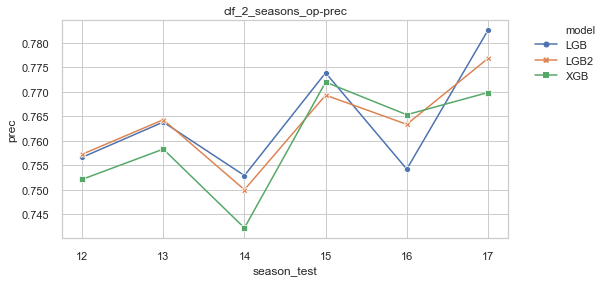

In [30]:
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,4))
name, res = get_result_by(experiment_name[:-3])

res = [x for x in res if x['model'][0] in model_names] 
plot_results(name[:-3], res, figsize=(8,4))

### Final validation

#### Dataset

In [15]:
fv_df = season_games[(season_games.SEASON >= 2016)]

##### Seasons

In [16]:
fv_df.SEASON.unique()

array([2016, 2017, 2018, 2019])

##### clean data

In [17]:
print(fv_df.shape)
fv_df = fv_df.dropna()
print(fv_df.isnull().sum().sum())
print(fv_df.isna().sum().sum())
print(fv_df.shape)

(4749, 261)
0
0
(4685, 261)


#### setup

In [18]:
exp_prefix = "clf_"
#exp_group_name = "clf_experiments"
exp_group_name = "clf_final_validation"
results_total = utils.deserialize_object(f'result_totals_{exp_group_name}', [])

fv_models = utils_exp.get_clf_models()

fv_sscv = utils.SeasonSeriesSplit(fv_df)
fv_df_sscv = fv_sscv.get_df()
fv_X = fv_df_sscv[exp_X_columns]
fv_y = fv_df_sscv[TARGET]

#### experiment

In [19]:
experiment_name = f"{exp_prefix}2_seasons_fv"

In [20]:
del_result_by(experiment_name)

folds, train_seasons, test_seasons = fv_sscv.split(train_size=2, test_size=1)
params = (experiment_name, fv_models, folds, train_seasons, test_seasons, fv_X, fv_y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment clf_2_seasons_fv
Done


,exp_name,model,prec_mean,prec_std,bal_acc_mean,bal_acc_std
4,clf_2_seasons_fv,RF,0.762396,0.033825,0.738084,0.020561
3,clf_2_seasons_fv,SVM,0.761851,0.029544,0.745272,0.016139
0,clf_2_seasons_fv,L2R,0.757738,0.028254,0.742014,0.013661
6,clf_2_seasons_fv,LGB,0.749895,0.025701,0.716310,0.007497
5,clf_2_seasons_fv,XGB,0.741749,0.025189,0.711492,0.009271
2,clf_2_seasons_fv,DT,0.700006,0.008087,0.650257,0.012661
1,clf_2_seasons_fv,KNN,0.659587,0.024073,0.613094,0.007160


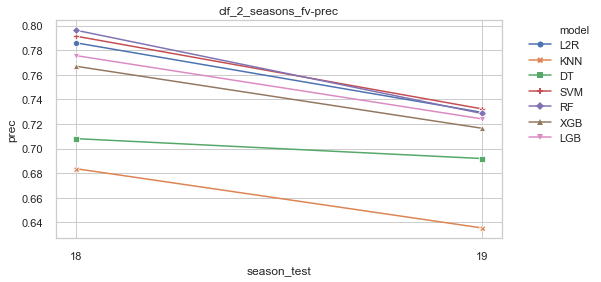

In [21]:
#### Visualize experiments results
name, res = get_result_by(experiment_name)
plot_results(name, res, figsize=(8,4))